In [9]:
import pandas as pd
import numpy as np
import os
from sklearn import preprocessing
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

> train과 test데이터 병합

In [10]:
DATA_DIR = 'space_Data'
datalist = []
for filename in os.listdir('space_Data')[::-1]:
    if filename in ['train.csv', 'test.csv']:
        filepath = os.path.join(DATA_DIR, filename)
        df = pd.read_csv(filepath)
        datalist.append(df)
    if filename in ['train.csv']:
        filepath = os.path.join(DATA_DIR, filename)
        train = pd.read_csv(filepath)
    if filename in ['test.csv']:
        filepath = os.path.join(DATA_DIR, filename)
        test = pd.read_csv(filepath)

merge_data = pd.concat(datalist)
merge_data = merge_data.reset_index(drop=True)
y_value = merge_data.pop('Transported').values
y_value = y_value[:8693] #train.shape이 (8693, 14)

> 뜯어보기

결측치 비율이 60%이상인 컬럼은 중요하지 않을 경우, 삭제하기 위해, 각 컬럼별 결측치 비율 확인  
결측치 비율이 60% 이상인 컬럼이 없으므로 모두 결측치 삽입해서 사용

In [11]:
total_count = merge_data.shape[0]
condition = (merge_data.isna().sum() > 0).values
(merge_data.isna().sum()/total_count)[condition].sort_values(ascending =False)

CryoSleep       0.023901
ShoppingMall    0.023593
Cabin           0.023053
VIP             0.022822
Name            0.022668
FoodCourt       0.022282
HomePlanet      0.022205
Spa             0.021897
Destination     0.021126
Age             0.020817
VRDeck          0.020663
RoomService     0.020278
dtype: float64

행성, 목적지에 어떤 값이 들어있을 수 있는지 확인

In [12]:
set_col = {}
for i in range(len(merge_data.columns)):
    if merge_data.iloc[:,i].dtypes == 'object':
        set_col[merge_data.columns[i]] = set(merge_data.iloc[:, i])

for k,v in set_col.items():
    if len(v)<100:
        print(k,v)

HomePlanet {nan, 'Mars', 'Earth', 'Europa'}
CryoSleep {False, True, nan}
Destination {nan, 'PSO J318.5-22', '55 Cancri e', 'TRAPPIST-1e'}
VIP {False, True, nan}


In [13]:
merge_data['Age'].apply(['min','max'])

min     0.0
max    79.0
Name: Age, dtype: float64

<Axes: >

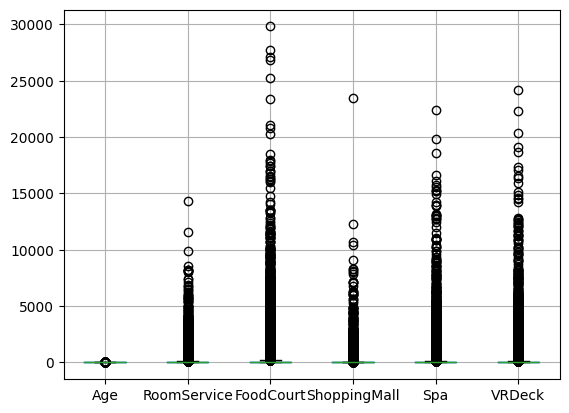

In [14]:
merge_data.boxplot()

*RoomService*,  *FoodCourt*,  *ShoppingMall*,  *Spa*,  *VRDeck*은 값의 편차가 큰 것으로 보여 해당 컬럼의 결측치를 0으로 대체함

> 전처리

1. 결측값 처리  
###### 문자형은 최빈값, / 실수, 정수형은 평균값 삽입
###### 지불금액 컬럼 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck'은 0 삽입

In [15]:
col_list = ['HomePlanet', 'CryoSleep', 'Destination', 'Age', 'VIP','Cabin','Name']
for col in col_list:
    if merge_data[col].dtypes == 'object':
        merge_data[col].fillna(merge_data[col].mode()[0], inplace=True)
    elif merge_data[col].dtypes != 'object':
        merge_data[col].fillna(merge_data[col].mean(), inplace=True)
        
money_list = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']  
for i in money_list:
    merge_data[i] = merge_data[i].fillna(0)       

C:\Users\samsung\AppData\Local\Temp\ipykernel_27500\4235341562.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merge_data[col].fillna(merge_data[col].mode()[0], inplace=True)
C:\Users\samsung\AppData\Local\Temp\ipykernel_27500\4235341562.py:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  merge_data[col].fi

2. 새로운 컬럼 생성 및 변경

| 새로운 컬럼명 | 설명 |
|:---|:---|
| _group_ | 가족끼리 왔으면 True, 아니면 False. <br/>PassengerId gggg_pp에서 동일한 gggg가 두 명 이상이면 가족으로 판단 |
| _deck_ | 'cabin'에서 갑판 |
| _num_ | 'cabin'에서 num |
| _side_ | 'cabin'에서 side(P좌측, S우측) |
| _money_ | 고급 편의 시설에 지불한 금액  <br/>RoomService, FoodCourt, ShoppingMall, Spa, VRDeck 을 합함 |
| _Age_ | 연령대로 바꿈, 나이는 0세부터 79세였으므로 0대~70대로 구성됨 |



- 변경  


|변경된 컬럼명|설명|
|:--|:--|
|_Age_ |연령대로 바꿈, 나이는 0세부터 79세였으므로 0대~70대로 구성됨|

In [16]:
merge_data['group'] = merge_data['PassengerId'].apply(lambda x: x.split('_')[0])  #어떤 그룹에 속하는지
merge_data['deck'] = merge_data['Cabin'].apply(lambda x: x.split('/')[0])
merge_data['num'] = merge_data['Cabin'].apply(lambda x: x.split('/')[1])
merge_data['side'] = merge_data['Cabin'].apply(lambda x: x.split('/')[2]) #객실이 좌측인지 우측인지
merge_data['money'] = merge_data['RoomService'] + merge_data['FoodCourt'] + merge_data['ShoppingMall'] + merge_data['Spa'] + merge_data['VRDeck']
merge_data.drop(columns=['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck'], inplace=True)
merge_data['Age'] = merge_data['Age']//10*10

family_list = merge_data[merge_data.groupby('group')['group'].transform('size') >= 2].index
merge_data['group'] = merge_data.index.isin(family_list).astype(str)

merge_data.drop(columns=['Name', 'PassengerId','num','Cabin'], axis=1, inplace=True)

3.범주형을 이진형으로 변경

In [17]:
merge_data['side'] = merge_data['side'].map({'S':0, 'P':1})
merge_data['HomePlanet'] = merge_data['HomePlanet'].map({'Earth':0, 'Europa':1, 'Mars':2})
merge_data['Destination'] = merge_data['Destination'].map({'TRAPPIST-1e':0, 'PSO J318.5-22':1, '55 Cancri e':2})
merge_data['group'] = merge_data['group'].map({'False':0, 'True':1})
merge_data['deck'] = merge_data['deck'].map({'F':0, 'E':1, 'T':2, 'A':3, 'G':4, 'D':5, 'C':6, 'B':7})
merge_data['CryoSleep'] = merge_data['CryoSleep'].map({False:0, True:1})
merge_data['VIP'] = merge_data['VIP'].map({False:0, True:1})

> merge_data데이터 전처리 후, 다시 train, test로 분할

In [18]:
train = merge_data[:8693]
train['Transported'] = y_value
test = merge_data[8693:]
train['Transported'] = train['Transported'].map({False : 0, True:1})

C:\Users\samsung\AppData\Local\Temp\ipykernel_27500\86187362.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Transported'] = y_value
C:\Users\samsung\AppData\Local\Temp\ipykernel_27500\86187362.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Transported'] = train['Transported'].map({False : 0, True:1})


In [19]:
sns.heatmap(round(train.corr(),2)
            ,annot=True
            ,annot_kws = dict(size = 8))

<Axes: >

Transported와의 상관계수 절댓값이 0.1 이상인 컬럼만 선택    :   
_HomePlanet_, _CryoSleep_, _Destination_, _group_, _deck_, _side_, _money_

> 가설

1. 목적지는 이탈에 영향을 주었다.  

2. 객실 방향(좌측, 우측)은 이탈에 영향을 주었다.

3. 가족 여부는 이탈에 영향을 주었다. 

4. 출발지는 이탈에 영향을 주었다.   

5. CryoSleep은 이탈에 영향을 주었다. 

6. 지불한 금액은 이탈에 영향을 주었다.

7. deck은 이탈에 영향을 주었다.


- 가설 1. 목적지는 이탈에 영향을 주었다.  

|         |Transported|Destination|
|--------:|----------:|----------:|
|        0|     False|TRAPPIST-1e|
|        1|     True|PSO J318.5-22|
|        2|           |55 Cancri e|

In [20]:
round(train[['Transported','Destination']].corr(),2)

,Transported,Destination
Transported,1.00,0.11
Destination,0.11,1.00


In [21]:
train.groupby('Destination')['Transported'].value_counts(normalize=True).unstack(fill_value=0)

Transported,0,1
Destination,,
0,0.527801,0.472199
1,0.496231,0.503769
2,0.390000,0.610000


In [22]:
train.groupby('Destination')['Transported'].value_counts(normalize=True).unstack(fill_value=0).plot(kind='bar', stacked=False, color = ['silver','red'])

plt.rc('font', family='Malgun Gothic')
plt.title('목적지별 이탈율')
plt.xlabel('목적지 행성')
plt.ylabel('이탈율')
plt.ylim(0,1.0)
plt.axhline(y=0.5, color='black', linestyle='--', linewidth=2)
plt.xticks(rotation = 0)

key_list = {'TRAPPIST-1e':0, 'PSO J318.5-22':1, '55 Cancri e':2,}.keys()
plt.xticks(range(len(key_list)), key_list);

###### 다른 행성은 모두 약 50% 이탈하였으나, 첫 목적지인 55 Cancri e 행성에서 내리려던 승객은 60%가 이탈한 것을 확인

- 가설 2. 객실 방향(좌측, 우측)은 이탈에 영향을 주었다.

|         |Transported|side|
|--------:|----------:|----------:|
|        0|     False|S|
|        1|     True|P|

In [23]:
round(train[['Transported','side']].corr(),2)

,Transported,side
Transported,1.0,-0.1
side,-0.1,1.0


In [24]:
train.groupby('side')['Transported'].value_counts(normalize=True).unstack(fill_value=0)

Transported,0,1
side,,
0,0.444963,0.555037
1,0.546425,0.453575


In [25]:
train.groupby('side')['Transported'].value_counts(normalize=True).unstack().plot(kind='bar', stacked=True, color=['green', 'red'])

plt.rc('font', family='Malgun Gothic')
plt.title('객실 방향에 따른 이탈율')
plt.ylim(0,1.0)
plt.axhline(y=0.5, color='black', linestyle='--', linewidth=5)
plt.xticks(rotation = 0)

key_list = {'S':0, 'P':1}.keys()
plt.xticks(range(len(key_list)), key_list);

###### 객실 방향이 S인 승객이 P인 승객보다 이탈율이 큼

객실 

- 가설 3. 가족 여부는 이탈에 영향을 주었다. 

|         |Transported|group|
|--------:|----------:|----------:|
|        0|     False|0|
|        1|     True|1|

In [26]:
round(train[['Transported','group']].corr(),2)

,Transported,group
Transported,1.00,0.11
group,0.11,1.00


In [27]:
train.groupby('group')['Transported'].value_counts(normalize=True).unstack()

Transported,0,1
group,,
0,0.547555,0.452445
1,0.433128,0.566872


In [28]:
train.groupby('group')['Transported'].value_counts(normalize=True).unstack().plot(kind='bar', stacked=True,color=['green', 'red'])

plt.rc('font', family='Malgun Gothic')
plt.title('가족여부에 따른 이탈율')
plt.xlabel('가족 여부', fontsize = 13)
plt.ylabel('이탈율')
plt.ylim(0,1.0)
plt.axhline(y=0.5, color='black', linestyle='--', linewidth=5)
plt.xticks(rotation = 0)

key_list = {'가족 아님':0, '가족임':1}.keys()
plt.xticks(range(len(key_list)), key_list);

###### 가족으로 탑승한 승객의 이탈율이 더 큼

- 가설 4. 출발지는 이탈에 영향을 주었다.   

|         |Transported|HomePlanet|
|--------:|----------:|----------:|
|        0|     False|Earth|
|        1|     True|Europa|
|        2|           |Mars|

In [29]:
round(train[['Transported','HomePlanet']].corr(),2)

,Transported,HomePlanet
Transported,1.00,0.12
HomePlanet,0.12,1.00


In [30]:
train.groupby('Destination')['HomePlanet'].value_counts(normalize=True).unstack()

HomePlanet,0,1,2
Destination,,,
0,0.550107,0.201082,0.248811
1,0.914573,0.023869,0.061558
2,0.400556,0.492222,0.107222


In [31]:
train.groupby('HomePlanet')['Transported'].value_counts(normalize=True).unstack().plot(kind='bar', stacked=True,color=['green', 'red'])

plt.rc('font', family='Malgun Gothic')
plt.title('출발지에 따른 이탈율')
plt.xlabel('출발지', fontsize = 13)
plt.ylabel('이탈율')
plt.ylim(0,1.0)
plt.axhline(y=0.5, color='black', linestyle='--', linewidth=5)
plt.xticks(rotation = 0)

key_list = {'Earth':0, 'Europa':1, 'Mars':2}.keys()
plt.xticks(range(len(key_list)), key_list);

###### Europa에서 출발한 승객의 이탈율이 가장 큰 것으로 나타남

- 가설 5. CryoSleep은 이탈에 영향을 주었다. 

|         |Transported|CryoSleep|
|--------:|----------:|----------:|
|        0|     False|False|
|        1|     True|True|

In [32]:
round(train[['Transported','CryoSleep']].corr(),2)

,Transported,CryoSleep
Transported,1.00,0.46
CryoSleep,0.46,1.00


In [33]:
train.groupby('CryoSleep')['Transported'].value_counts(normalize=True).unstack()

Transported,0,1
CryoSleep,,
0,0.664958,0.335042
1,0.182417,0.817583


In [34]:
train.groupby('CryoSleep')['Transported'].value_counts(normalize=True).unstack().plot(kind='bar', stacked=True,color=['green', 'red'])

plt.rc('font', family='Malgun Gothic')
plt.title('CryoSleep에 따른 이탈율')
plt.xlabel('CryoSleep', fontsize = 13)
plt.ylabel('이탈율')
plt.ylim(0,1.0)
plt.axhline(y=0.5, color='black', linestyle='--', linewidth=5)
plt.xticks(rotation = 0)


key_list = {'False':0, 'True':1}.keys()
plt.xticks(range(len(key_list)), key_list);

###### 냉동 수면을 하지 않은 승객은 약 20%이탈한 반면, 냉동 수면 중이던 승객은 객실에 갇혀있었고, 냉동 수면한 승객의 80%가 이탈함

- 가설 6. 지불한 금액은 이탈에 영향을 주었다.

In [35]:
round(train[['Transported','money']].corr(),2)

,Transported,money
Transported,1.0,-0.2
money,-0.2,1.0


- 가설 7. deck은 이탈에 영향을 주었다.

|         |0|1|2|3|4|5|6|7|
|--------:|---:|---:|---:|---:|---:|---:|---:|---:|
|Transported|False|True|
|deck|F|E|T|A|G|D|C|B|

In [36]:
round(train[['Transported','deck']].corr(),2)

,Transported,deck
Transported,1.00,0.18
deck,0.18,1.00


In [37]:
train.groupby('deck')['Transported'].value_counts(normalize=True).unstack()

Transported,0,1
deck,,
0,0.560129,0.439871
1,0.642694,0.357306
2,0.800000,0.200000
3,0.503906,0.496094
4,0.484772,0.515228
5,0.566946,0.433054
6,0.319946,0.680054
7,0.265725,0.734275


In [38]:
train.groupby('deck')['Transported'].value_counts(normalize=True).unstack().plot(kind='bar', stacked=True,color=['green', 'orange'])

plt.rc('font', family='Malgun Gothic')
plt.title('deck에 따른 이탈율')
plt.xlabel('deck', fontsize = 13)
plt.ylabel('이탈율')
plt.ylim(0,1.0)
plt.axhline(y=0.5, color='black', linestyle='--', linewidth=5)
plt.xticks(rotation = 0)

key_list = {'F':0, 'E':1, 'T':2, 'A':3, 'G':4, 'D':5, 'C':6, 'B':7}.keys()
plt.xticks(range(len(key_list)), key_list);

###### 갑판이 B, C, G 순으로 이탈율이 컸고, 그중에서도 B와 C는 다른 갑판들과 달리 이탈율이 눈에 띌 정도로 큼

> 예측

In [39]:
from sklearn.linear_model import LogisticRegression

X = train[['HomePlanet', 'CryoSleep', 'Destination', 'group', 'deck','side', 'money']].values
y = train["Transported"].values

clf = LogisticRegression(random_state=0).fit(X, y)

from sklearn.metrics import accuracy_score

c:\Users\samsung\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [40]:
accuracy_score(clf.predict(X), y)

0.7259864258598873

In [41]:
X = test[['HomePlanet', 'CryoSleep', 'Destination', 'group', 'deck','side', 'money']].values
clf.predict(X)

array([1, 0, 1, ..., 1, 0, 1], dtype=int64)